In [1]:
from prody import *
from pylab import *
import numpy as np
from scipy import stats
import pandas as pd
from Bio import AlignIO
from Bio import SeqIO
from Bio import Seq
from random import randint
import sklearn
from sklearn import metrics
from sklearn.metrics.cluster import normalized_mutual_info_score as mi
import os

## Read full MSA

In [2]:
msa = AlignIO.read("/Users/yanghanning/Desktop/ComputationalBiology/PF00440_full.fasta", "fasta")
nrow, ncol = shape(msa)

## Randomly select 2000 index

In [14]:
index = []
n = 2000

for i in range(n):
    index.append(randint(0, nrow))

In [15]:
index = np.array(index)
index.shape[0]

2000

In [16]:
sum = 0
for i in range(n):
    for j in range(n):
        if (index[i] == index[j]) and (i != j):
            sum += 1
        else:
            sum += 0
            
sum

92

## Generate a 2000 subsequence

In [4]:
with open("/Users/yanghanning/Desktop/ComputationalBiology/PF00440_random.fasta", "w") as o:
    for i in index:
        SeqIO.write(msa[i], o, "fasta")

## Ungap the MSA

In [ ]:
with open("/Users/yanghanning/Desktop/ComputationalBiology/PF00440_random_ungap.fasta", "w") as o:
    for record in AlignIO.read("/Users/yanghanning/Desktop/ComputationalBiology/PF00440_random.fasta", "fasta"):
        record.seq = record.seq.ungap("-")
        SeqIO.write(record, o, "fasta")

## Pad MSA so that they have same length

In [ ]:
input_file = '/Users/yanghanning/Desktop/ComputationalBiology/PF00440_random_ungap.fasta'
records = SeqIO.parse(input_file, 'fasta')
records = list(records) # make a copy, otherwise our generator
                        # is exhausted after calculating maxlen
maxlen = max(len(record.seq) for record in records)

# pad sequences so that they all have the same length
for record in records:
    if len(record.seq) != maxlen:
        sequence = str(record.seq).ljust(maxlen, '.')
        record.seq = Seq.Seq(sequence)
assert all(len(record.seq) == maxlen for record in records)

# write to temporary file and do alignment
output_file = '{}_padded.fasta'.format(os.path.splitext(input_file)[0])
with open(output_file, 'w') as f:
    SeqIO.write(records, f, 'fasta')
msa = AlignIO.read(output_file, "fasta")

nrow, ncol = shape(msa)

In [35]:
input_file = '/Users/yanghanning/Desktop/ComputationalBiology/PF00440_random_ungap_padded.fasta'
records = SeqIO.parse(input_file, 'fasta')
records = list(records)
records = np.array(records)
# print(records[1,1])
#for record in records:
    #print(record.seq)

## Define mutual information function

In [36]:
def mutual_Info(X, Y):
    # count frequency of each element in X
    d_x = dict()  # dictionary of X
    for x in X:
        if x in d_x:
            d_x[x] += 1
        else:
            d_x[x] = 1
    # calculate probability of each element in X
    p_x = dict()
    for x in d_x.keys():
        p_x[x] = d_x[x] / X.size

    # count frequency of each element in Y
    d_y = dict()  # dictionary of Y
    for y in Y:
        if y in d_y:
            d_y[y] += 1
        else:
            d_y[y] = 1
    # calculate probability of each element in Y
    p_y = dict()
    for y in d_y.keys():
        p_y[y] = d_y[y] / Y.size

    # count the number of occurence of each combination (x,y)
    d_xy = dict()  # dictionary of each (x,y)
    for i in range(X.size):
        if (X[i], Y[i]) in d_xy:
            d_xy[X[i], Y[i]] += 1
        else:
            d_xy[X[i], Y[i]] = 1
    # calculate probability of each (x,y)
    p_xy = dict()
    for xy in d_xy.keys():
        p_xy[xy] = d_xy[xy] / X.size

    # initialize MI value
    mi = 0
    for xy in p_xy.keys():
        mi += p_xy[xy] * np.log(p_xy[xy] / (p_x[xy[0]] * p_y[xy[1]]))
    
    return mi

In [37]:
ncol = records.shape[1]
ncol

54

## Compute mutual information matrix

In [38]:
%%time

mutual_info = np.zeros((ncol,ncol))
for i in range(ncol):
    mutual_info[i][i] = mutual_Info(records[:,i], records[:,i])
    for j in range(i):
        mutual_info[i][j] = mutual_Info(records[:,i], records[:,j])

        
for i in range(ncol):
    for j in range(i,ncol):
        mutual_info[i][j] = mutual_info[j][i]

CPU times: user 7.23 s, sys: 63.6 ms, total: 7.3 s
Wall time: 7.38 s


In [39]:
mutual_info

array([[1.41437810e+00, 1.62105012e-01, 1.34518250e-01, ...,
        9.71741349e-04, 9.71741349e-04, 9.71741349e-04],
       [1.62105012e-01, 1.81472653e+00, 1.47232264e-01, ...,
        2.34261452e-03, 2.34261452e-03, 2.34261452e-03],
       [1.34518250e-01, 1.47232264e-01, 2.31800870e+00, ...,
        2.05850408e-03, 2.05850408e-03, 2.05850408e-03],
       ...,
       [9.71741349e-04, 2.34261452e-03, 2.05850408e-03, ...,
        8.60040229e-03, 8.60040229e-03, 8.60040229e-03],
       [9.71741349e-04, 2.34261452e-03, 2.05850408e-03, ...,
        8.60040229e-03, 8.60040229e-03, 8.60040229e-03],
       [9.71741349e-04, 2.34261452e-03, 2.05850408e-03, ...,
        8.60040229e-03, 8.60040229e-03, 8.60040229e-03]])

## Display mutual information

(<matplotlib.image.AxesImage at 0x7fdc354cf520>,
 <matplotlib.colorbar.Colorbar at 0x7fdc1be81490>)

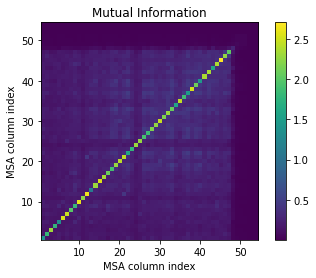

In [40]:
showMutinfoMatrix(mutual_info)

In [42]:
re_mutual_info = mutual_info.reshape(ncol*ncol,1)
re_mutual_info

array([[1.4143781 ],
       [0.16210501],
       [0.13451825],
       ...,
       [0.0086004 ],
       [0.0086004 ],
       [0.0086004 ]])

## Save mutual infomation matrix as a (147$*$147)$*$1 matrix

In [ ]:
writeArray('/Users/yanghanning/Desktop/ComputationalBiology/re_mutual_info.txt', re_mutual_info)

## Define normalized mutual information function

In [43]:
def MI(A, B):
    total = len(A)
    A_ids = set(A)
    B_ids = set(B)
    # calculate MI
    MI = 0
    eps = 1.4e-45
    for idA in A_ids:
        for idB in B_ids:
            idAOccur = np.where(A==idA)    
            idBOccur = np.where(B==idB)
            idABOccur = np.intersect1d(idAOccur,idBOccur)   # Find the intersection of two arrays.
            px = 1.0*len(idAOccur[0])/total
            py = 1.0*len(idBOccur[0])/total
            pxy = 1.0*len(idABOccur)/total
            MI = MI + pxy*math.log(pxy/(px*py)+eps,2)
    # normalize MI
    Hx = 0
    for idA in A_ids:
        idAOccurCount = 1.0*len(np.where(A==idA)[0])
        Hx = Hx - (idAOccurCount/total)*math.log(idAOccurCount/total+eps,2)
    
    Hy = 0
    for idB in B_ids:
        idBOccurCount = 1.0*len(np.where(B==idB)[0])
        Hy = Hy - (idBOccurCount/total)*math.log(idBOccurCount/total+eps,2)
    
    if (Hx == 0) and (Hy == 0):
        NMI = 1.0
    else:
        NMI = 2.0*float(MI)/float(Hx+Hy)
        
    return NMI
    
    

## Compute normalized mutual information matrix

In [44]:
%%time

normal_mutuInfo = np.zeros((ncol,ncol))
for i in range(ncol):
    normal_mutuInfo[i][i] = sklearn.metrics.normalized_mutual_info_score(records[:,i], records[:,i])
    for j in range(i):
        normal_mutuInfo[i][j] = sklearn.metrics.normalized_mutual_info_score(records[:,i], records[:,j])

        
for i in range(ncol):
    for j in range(i,ncol):
        normal_mutuInfo[i][j] = normal_mutuInfo[j][i]

CPU times: user 2.95 s, sys: 19.8 ms, total: 2.97 s
Wall time: 2.99 s


In [45]:
normal_mutuInfo

array([[1.        , 0.10040245, 0.07208162, ..., 0.00136579, 0.00136579,
        0.00136579],
       [0.10040245, 1.        , 0.07125173, ..., 0.0025696 , 0.0025696 ,
        0.0025696 ],
       [0.07208162, 0.07125173, 1.        , ..., 0.00176953, 0.00176953,
        0.00176953],
       ...,
       [0.00136579, 0.0025696 , 0.00176953, ..., 1.        , 1.        ,
        1.        ],
       [0.00136579, 0.0025696 , 0.00176953, ..., 1.        , 1.        ,
        1.        ],
       [0.00136579, 0.0025696 , 0.00176953, ..., 1.        , 1.        ,
        1.        ]])

## Display normalized mutual information

(<matplotlib.image.AxesImage at 0x7fdc1c20ceb0>,
 <matplotlib.colorbar.Colorbar at 0x7fdc1be4d7c0>)

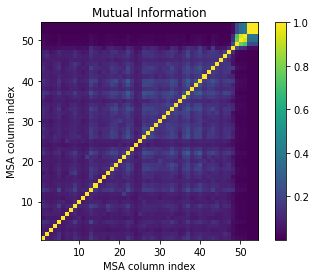

In [46]:
showMutinfoMatrix(normal_mutuInfo)

In [47]:
re_normal_mutuInfo = normal_mutuInfo.reshape(ncol*ncol,1)
re_normal_mutuInfo

array([[1.        ],
       [0.10040245],
       [0.07208162],
       ...,
       [1.        ],
       [1.        ],
       [1.        ]])

## Save normalized mutual infomation matrix as a (147$*$147)$*$1 matrix

In [ ]:
writeArray('/Users/yanghanning/Desktop/ComputationalBiology/re_normal_mutuInfo.txt', re_normal_mutuInfo)

## Define a threshold to creat contact map

In [49]:
thresh = 0.05
contacts = np.zeros((ncol,ncol))
for i in range(ncol):
    for j in range(ncol):
        if normal_mutuInfo[i,j] >= thresh:
            contacts[i,j] = 1
        else:
            contacts[i,j] = 0

## Sum the number of 1s in contact map

In [50]:
contacts
re_contacts = contacts.reshape(ncol*ncol,1)

sum(re_contacts)

2306.0

## Save contact map as a (147$*$147)$*$1 matrix

In [51]:
writeArray('/Users/yanghanning/Desktop/ComputationalBiology/gap0.05.txt',re_contacts)

'/Users/yanghanning/Desktop/ComputationalBiology/gap0.05.txt'